In [1]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import nltk
import spacy
import random 
import gensim
import smart_open
from gensim.models.coherencemodel import CoherenceModel

spacy.load('en')
from spacy.lang.en import English
parser = English()

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaitlinchaung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaitlinchaung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Further feature engineering with topic modeling

In [2]:
def get_topic_months(processed_text):
    
    """
    Get topic months
    """
    
    processed_text = prepare_text_for_lda(processed_text)
    processed_text_bow = dictionary.doc2bow(processed_text)
    topic_scores = ldamodel.get_document_topics(processed_text_bow)
    best_topic = float(pd.DataFrame(topic_scores,columns=['topic','prob']).sort_values(by=['prob'],ascending=False).head(1).topic.values[0])
    rank1_month = topic_months[topic_months.Dominant_Topic == best_topic].Rank1_month.values[0]
    return (rank1_month)

In [3]:
def tokenize(text):
    
    """
    Take text and return list of tokens
    """

    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [4]:
def get_lemma(word):
    
    """
    Get meaning of words, syn, antonym
    """
    
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma 

In [5]:
def get_lemma2(word):
    
    """
    Get root word
    """
    
    return WordNetLemmatizer().lemmatize(word)

In [6]:
def prepare_text_for_lda(text):
    
    """
    Apply all filter steps to text and filter out stop words
    """
    
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

Read in working data set.

In [ ]:
working_data = pd.read_csv("working_data.csv")

Read in titles and get rid of characters.

In [8]:
working_data = pd.read_csv("working_data.csv")
working_data['MonthYear'] = working_data.Year.astype(str) + '-' + working_data.Month.astype(str)

abstracts = pd.DataFrame(working_data.Abstract)
abstracts['Abstracts_processed'] = working_data.Abstract.str.replace('[,\.!?]', '',regex=True)

Clean up all text to prepare into corpus.

In [9]:
text_data = []
for line in abstracts.Abstracts_processed:
    tokens = prepare_text_for_lda(line)
    text_data.append(tokens)

Create dictionary from data(word: word index).
Convert dictionary to bag of words(word index: word count).

In [10]:
from gensim import corpora 
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [15]:
def get_coherence(num_topics):
    
    """
    Get coherence from num_topics
    """

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15,eta=0.01)   
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

Find the optimal number of topics.

In [16]:
plot=False

if plot == True:
    plotting_num_topics = []
    for i in range(45,48):
        coherence = get_coherence(i)
        plotting_num_topics.append(coherence)
        print(i)
        print(coherence)
        print("")

    with open('coherence_num_topics.txt','wb') as filehandle:
        pickle.dump(plotting_num_topics, filehandle)  
    
    plt.plot(range(45,48), plotting_num_topics)
    plt.xlabel('numTopics');
    plt.ylabel('Coherence');

In [378]:
with open('numTopics_30_45.txt','w') as filehandle:
    for listitem in plotting_num_topics:
        filehandle.write('%s\n' % listitem)

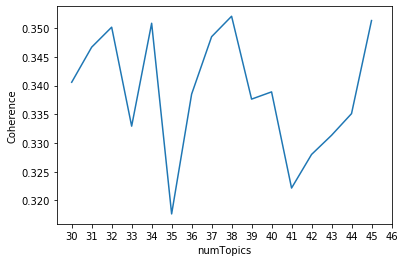

In [377]:
plt.plot(range(30,46), plotting_num_topics)
plt.xlabel('numTopics');
plt.ylabel('Coherence');
plt.xticks(np.arange(30,47,1));

Make LDA models with large and small n topics.

In [11]:
ldamodel_small = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=dictionary, passes=15,alpha='auto',eta=0.01,minimum_phi_value=0.01)
ldamodel_small.save('paper_model_small.gensim')
topics_small = ldamodel_small.print_topics(num_words=4)

ldamodel_large = gensim.models.ldamodel.LdaModel(corpus, num_topics = 38, id2word=dictionary, passes=15,alpha='auto',eta=0.01,minimum_phi_value=0.01)
ldamodel_large.save('paper_model_large.gensim')
topics_large = ldamodel_large.print_topics(num_words=4)

In [12]:
topics_small

[(0,
  '0.014*"cancer" + 0.010*"mutation" + 0.008*"expression" + 0.007*"protein"'),
 (1, '0.014*"patient" + 0.011*"variant" + 0.011*"study" + 0.009*"mutation"'),
 (2, '0.017*"gene" + 0.015*"expression" + 0.011*"identify" + 0.010*"study"'),
 (3, '0.006*"genetic" + 0.005*"study" + 0.005*"strain" + 0.005*"result"'),
 (4,
  '0.015*"genome" + 0.011*"sequence" + 0.009*"genetic" + 0.007*"population"')]

In [20]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=text_data):
    
    """
    Assign topics to dataset
    """
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Export topics to dataset to dataframe.

In [123]:
df_topic_sents_keywords_small = format_topics_sentences(ldamodel=ldamodel_small, corpus=corpus, texts=text_data)
df_dominant_topic_small = df_topic_sents_keywords_small.reset_index()
df_dominant_topic_small.columns = ['Document_No', 'Dominant_Topic_small', 'Topic_Perc_Contrib_small', 'Keywords_small', 'Text_small']


df_topic_sents_keywords_large = format_topics_sentences(ldamodel=ldamodel_large, corpus=corpus, texts=text_data)
df_dominant_topic_large = df_topic_sents_keywords_large.reset_index()
df_dominant_topic_large.columns = ['Document_No', 'Dominant_Topic_large', 'Topic_Perc_Contrib_large', 'Keywords_large', 'Text_large']

Calculate norm contribution
(norm_contrib = num_occurances_per_month * avg_perc_contrib)

In [181]:
features_small = pd.concat([df_dominant_topic_small,working_data],1)[['Document_No','Dominant_Topic_small','Topic_Perc_Contrib_small','Citations','Accesses','MonthYear','NumAuthors','lenTitle','ImpactFactor','NatureAC','NatureFC']]

avg_contrib_per_topic_small = features_small.groupby(['Dominant_Topic_small','MonthYear'])[['Topic_Perc_Contrib_small']].mean()
avg_contrib_per_topic_small.columns = ['avg_TPC_small']
avg_contrib_per_topic_small = avg_contrib_per_topic_small.reset_index()

counts_per_topic_small = features_small.groupby(['Dominant_Topic_small','MonthYear'])[['MonthYear']].count()
counts_per_topic_small.columns = ['Counts_small']
counts_per_topic_small = counts_per_topic_small.reset_index()

norm_contrib_per_topic_small = pd.merge(avg_contrib_per_topic_small,counts_per_topic_small, on=['Dominant_Topic_small','MonthYear'])
norm_contrib_per_topic_small['norm_contrib_small'] = norm_contrib_per_topic_small.Counts_small * norm_contrib_per_topic_small.avg_TPC_small

Get top 3 most relavent months for each topic - small topic model. Relavence = 3 mfonths with highest norm_contrib, sorted by date

In [182]:
topics = norm_contrib_per_topic_small.Dominant_Topic_small.unique()
rel_months = []
for topic in topics:
    month = norm_contrib_per_topic_small[norm_contrib_per_topic_small.Dominant_Topic_small == topic].sort_values(by=['avg_TPC_small'], ascending=False).head(1).MonthYear.values[0]
    rel_months.append([topic, month])

topic_months_small = pd.DataFrame(rel_months)
topic_months_small.columns = ['Dominant_Topic_small','Rank1_month_small']
topic_months_small.to_csv("topics_small_relavent_months.csv",index=False)

Determine Relevance score.

In [183]:
features_small = pd.merge(features_small, topic_months_small, on=['Dominant_Topic_small'])
features_small = pd.merge(features_small, norm_contrib_per_topic_small, on=['Dominant_Topic_small','MonthYear'])

features_small['datetime_MonthYear'] = pd.to_datetime((features_small.MonthYear) + str('-01'), format='%Y-%m-%d')
features_small['datetime_Rank1_MonthYear_small'] = pd.to_datetime(features_small.Rank1_month_small+ str('-01'), format='%Y-%m-%d')

features_small['delta_Months_small'] = (features_small.datetime_Rank1_MonthYear_small - features_small.datetime_MonthYear).dt.days
features_small['delta_AvgTPC_small'] = features_small.avg_TPC_small - features_small.Topic_Perc_Contrib_small


"""
Clean up df
"""

features_small[['pubYear','pubMonth']]= features_small.MonthYear.str.split('-', expand=True)
features_small = features_small.drop(columns=['datetime_MonthYear','datetime_Rank1_MonthYear_small','NatureFC','MonthYear','Rank1_month_small'])


Calculate norm contribution (norm_contrib = num_occurances_per_month * avg_perc_contrib)

In [184]:
features_large = pd.concat([df_dominant_topic_large,working_data],1)[['Document_No','Dominant_Topic_large','Topic_Perc_Contrib_large','Citations','Accesses','MonthYear','NumAuthors','lenTitle','ImpactFactor','NatureAC','NatureFC']]

avg_contrib_per_topic_large = features_large.groupby(['Dominant_Topic_large','MonthYear'])[['Topic_Perc_Contrib_large']].mean()
avg_contrib_per_topic_large.columns = ['avg_TPC_large']
avg_contrib_per_topic_large = avg_contrib_per_topic_large.reset_index()

counts_per_topic_large = features_large.groupby(['Dominant_Topic_large','MonthYear'])[['MonthYear']].count()
counts_per_topic_large.columns = ['Counts_large']
counts_per_topic_large = counts_per_topic_large.reset_index()

norm_contrib_per_topic_large = pd.merge(avg_contrib_per_topic_large,counts_per_topic_large, on=['Dominant_Topic_large','MonthYear'])
norm_contrib_per_topic_large['norm_contrib_large'] = norm_contrib_per_topic_large.Counts_large * norm_contrib_per_topic_large.avg_TPC_large

Get top 3 most relavent months for each topic - large topic model. Relavence = 3 months with highest norm_contrib, sorted by date

In [185]:
topics = norm_contrib_per_topic_large.Dominant_Topic_large.unique()
rel_months = []
for topic in topics:
    month = norm_contrib_per_topic_large[norm_contrib_per_topic_large.Dominant_Topic_large == topic].sort_values(by=['avg_TPC_large'], ascending=False).head(1).MonthYear.values[0]
    rel_months.append([topic, month])

topic_months_large = pd.DataFrame(rel_months)
topic_months_large.columns = ['Dominant_Topic_large','Rank1_month_large']
topic_months_large.to_csv("topics_large_relavent_months.csv",index=False)

In [186]:
features_large = pd.merge(features_large, topic_months_large, on=['Dominant_Topic_large'])
features_large = pd.merge(features_large, norm_contrib_per_topic_large, on=['Dominant_Topic_large','MonthYear'])

features_large['datetime_MonthYear'] = pd.to_datetime((features_large.MonthYear) + str('-01'), format='%Y-%m-%d')
features_large['datetime_Rank1_MonthYear_large'] = pd.to_datetime(features_large.Rank1_month_large+ str('-01'), format='%Y-%m-%d')

features_large['delta_Months_large'] = (features_large.datetime_Rank1_MonthYear_large - features_large.datetime_MonthYear).dt.days
features_large['delta_AvgTPC_large'] = features_large.avg_TPC_large - features_large.Topic_Perc_Contrib_large


"""
Clean up df
"""

features_large[['pubYear','pubMonth']]= features_large.MonthYear.str.split('-', expand=True)
features_large = features_large.drop(columns=['datetime_MonthYear','datetime_Rank1_MonthYear_large','MonthYear','Rank1_month_large','NatureFC'])

In [188]:
features = pd.merge(features_large,features_small,on=['Document_No','Citations','Accesses','NumAuthors','lenTitle','ImpactFactor','NatureAC','pubYear','pubMonth'])

In [189]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1773
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Document_No               1774 non-null   int64  
 1   Dominant_Topic_large      1774 non-null   float64
 2   Topic_Perc_Contrib_large  1774 non-null   float64
 3   Citations                 1774 non-null   object 
 4   Accesses                  1774 non-null   object 
 5   NumAuthors                1774 non-null   int64  
 6   lenTitle                  1774 non-null   int64  
 7   ImpactFactor              1774 non-null   float64
 8   NatureAC                  1774 non-null   int64  
 9   avg_TPC_large             1774 non-null   float64
 10  Counts_large              1774 non-null   int64  
 11  norm_contrib_large        1774 non-null   float64
 12  delta_Months_large        1774 non-null   int64  
 13  delta_AvgTPC_large        1774 non-null   float64
 14  pubYear 

Create boolean feature for if a journal is in the top publishing ranks in Nature.

In [190]:
features.NatureAC[features.NatureAC < 141] = 0
features.NatureAC[features.NatureAC > 141] = 1

Save features to flat file.

In [191]:
features.to_csv("features.csv",index=False)

In [178]:
features

,Dominant_Topic_large,Topic_Perc_Contrib_large,Citations,Accesses,NumAuthors,lenTitle,ImpactFactor,NatureAC,avg_TPC_large,Counts_large,...,delta_AvgTPC_large,pubYear,pubMonth,Dominant_Topic_small,Topic_Perc_Contrib_small,avg_TPC_small,Counts_small,norm_contrib_small,delta_Months_small,delta_AvgTPC_small
0,22.0,0.7866,4,1030,7,15,4.011,False,0.591850,6,...,-0.194750,2018,5,2.0,0.9973,0.802729,21,16.8573,-30,-0.194571
1,22.0,0.7698,9,1139,5,13,4.011,False,0.591850,6,...,-0.177950,2018,5,0.0,0.9975,0.907250,4,3.6290,-30,-0.090250
2,22.0,0.4653,2,1071,9,14,4.011,False,0.591850,6,...,0.126550,2018,5,1.0,0.5147,0.746611,9,6.7195,-30,0.231911
3,22.0,0.5543,16,1766,15,9,11.878,False,0.591850,6,...,0.037550,2018,5,3.0,0.4053,0.757283,23,17.4175,-30,0.351983
4,22.0,0.3169,23,2922,27,17,25.455,True,0.591850,6,...,0.274950,2018,5,0.0,0.9976,0.907250,4,3.6290,-30,-0.090350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,13.0,0.9934,12,6536,10,9,4.011,False,0.844467,3,...,-0.148933,2017,7,3.0,0.9980,0.844480,15,12.6672,274,-0.153520
1770,13.0,0.8378,5,352,14,7,3.179,False,0.844467,3,...,0.006667,2017,7,0.0,0.7978,0.858991,11,9.4489,274,0.061191
1771,13.0,0.8373,36,3664,81,15,11.878,False,0.837300,1,...,0.000000,2018,6,1.0,0.9979,0.883557,7,6.1849,-61,-0.114343
1772,13.0,0.9952,4,335,6,9,3.179,True,0.995200,1,...,0.000000,2018,5,3.0,0.8663,0.757283,23,17.4175,-30,-0.109017
